In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


from catboost import CatBoostRegressor
import lightgbm as lgb

from skimpy import skim, generate_test_data

In [2]:
df_test= pd.read_csv(r"D:\Python_Programming\Projects\House_Prices\house-prices-advanced-regression-techniques\test.csv")
df_train= pd.read_csv(r"D:\Python_Programming\Projects\House_Prices\house-prices-advanced-regression-techniques\train.csv")

In [3]:
df_train.shape

(1460, 81)

In [4]:
df_test.shape

(1459, 80)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
avg_lotfrontage_by_mssubclass = df_test.groupby('MSSubClass')['LotFrontage'].mean()

df_test['LotFrontage'] = df_test.apply(
    lambda row: avg_lotfrontage_by_mssubclass[row['MSSubClass']] if pd.isna(row['LotFrontage']) else row['LotFrontage'],
    axis=1
)
df_test['LotFrontage']=df_test['LotFrontage'].fillna(df_test['LotFrontage'].mean())

df_test['MSZoning']=df_test['MSZoning'].fillna(df_test['MSZoning'].mode()[0])

#replace_alley={"Grvl":2,"Pave":1}
#df_test["Alley"]=df_test['Alley'].replace(replace_alley)
df_test['Alley']=df_test['Alley'].fillna(0)

df_test['Utilities'] = df_test['Utilities'].fillna(method='bfill')

df_test['Exterior1st']=df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0])
df_test['Exterior2nd']=df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0])

df_test['MasVnrType']=df_test['MasVnrType'].fillna(df_test['MasVnrType'].mode()[0])
df_test['MasVnrArea']=df_test['MasVnrArea'].fillna(df_test['MasVnrArea'].mean())

df_test['BsmtQual']=df_test['BsmtQual'].fillna(0)
df_test.loc[df_test['BsmtQual'] == 0, 'BsmtCond'] = 0
df_test['BsmtCond']=df_test['BsmtCond'].fillna(df_test['BsmtCond'].mode()[0])
df_test['BsmtExposure']=df_test['BsmtExposure'].fillna(0)
df_test['BsmtFinType1']=df_test['BsmtFinType1'].fillna(0)
df_test['BsmtFinSF1']=df_test['BsmtFinSF1'].fillna(0)# 1 value missing but the bsmtfintype1 is nan so no basement
df_test['BsmtFinType2']=df_test['BsmtFinType2'].fillna(0)
df_test['BsmtFinSF2']=df_test['BsmtFinSF2'].fillna(0)# 1 value missing but the bsmtfintype1 is nan so no basement
df_test['BsmtUnfSF']=df_test['BsmtUnfSF'].fillna(0)#BsmtFinSF1 and BsmtFinSF2 is na so no basement to finish
df_test['TotalBsmtSF']=df_test['TotalBsmtSF'].fillna(0)#BsmtFinSF1 and BsmtFinSF2 is na so no basement to finish
df_test['BsmtFullBath']=df_test['BsmtFullBath'].fillna(0)#There is no basement for these
df_test['BsmtHalfBath']=df_test['BsmtHalfBath'].fillna(0)#There is no basement for these
df_test['Functional']=df_test['Functional'].fillna('Typ')#assume Tupical documentation
df_test['FireplaceQu']=df_test['FireplaceQu'].fillna(0)#No fireplace
df_test['GarageType']=df_test['GarageType'].fillna(0)

df_test.loc[df_test['GarageType'] == 0, 'GarageYrBlt'] = 0 # only the nans two detached garages have nans

avg_garage_year_by_GarageTypes = df_test.groupby('GarageType')['GarageYrBlt'].mean()

df_test['GarageYrBlt'] = df_test.apply(
    lambda row: avg_garage_year_by_GarageTypes[row['GarageType']] if pd.isna(row['GarageYrBlt']) else row['GarageYrBlt'],
    axis=1
)

df_test.loc[df_test['GarageType'] == 0, 'GarageFinish'] = 0 

df_test['GarageFinish']=df_test['GarageFinish'].fillna('Fin')# assume it is finished

avg = df_test.groupby('GarageType')['GarageCars'].mean()

df_test['GarageCars'] = df_test.apply(
    lambda row: avg[row['GarageType']] if pd.isna(row['GarageCars']) else row['GarageCars'],
    axis=1
)
avg = df_test.groupby('GarageType')['GarageArea'].mean()

df_test['GarageArea'] = df_test.apply(
    lambda row: avg[row['GarageType']] if pd.isna(row['GarageArea']) else row['GarageArea'],
    axis=1
)

df_test.loc[df_test['GarageType'] == 0, 'GarageQual'] = 0 
df_test.loc[df_test['GarageType'] == 0, 'GarageCond'] = 0 
df_test['GarageQual']=df_test['GarageQual'].fillna(df_test['GarageQual'].mode()[0])
df_test['GarageCond']=df_test['GarageCond'].fillna(df_test['GarageCond'].mode()[0])

df_test['KitchenQual']=df_test['KitchenQual'].fillna('TA')

df_test.loc[df_test['PoolArea'] == 0, 'PoolQC'] = 0 
df_test['PoolQC']=df_test['PoolQC'].fillna('TA')# assing average to any other nan where there is a pool


df_test['Fence']=df_test['Fence'].fillna(0)
df_test['MiscFeature']=df_test['MiscFeature'].fillna(0)
df_test['SaleType']=df_test['SaleType'].fillna('Other')# assume as other

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\3185827646.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test['Utilities'] = df_test['Utilities'].fillna(method='bfill')


In [7]:
print(df_test['PoolQC'].value_counts())
columns_with_nan_bstcond = df_test[(pd.isna(df_test['PoolQC'])) ]#& df_test['KitchenQual']!=0]
print(columns_with_nan_bstcond[['PoolArea', 'PoolQC']])

PoolQC
0     1453
TA       3
Ex       2
Gd       1
Name: count, dtype: int64
Empty DataFrame
Columns: [PoolArea, PoolQC]
Index: []


In [8]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [9]:
#Fill in missing data  for trianing data
avg_lotfrontage_by_mssubclass = df_train.groupby('MSSubClass')['LotFrontage'].mean()

df_train['LotFrontage'] = df_train.apply(
    lambda row: avg_lotfrontage_by_mssubclass[row['MSSubClass']] if pd.isna(row['LotFrontage']) else row['LotFrontage'],
    axis=1
)

#replace_alley={"Grvl":2,"Pave":1}
#df_train["Alley"]=df_train['Alley'].replace(replace_alley)
df_train['Alley']=df_train['Alley'].fillna(0)

#replace_MasVnrType={"BrkCmn":4,"BrkFace":3,"CBlock":2,"Stone":1}
#df_train["MasVnrType"]=df_train['MasVnrType'].replace(replace_MasVnrType)
df_train['MasVnrType']=df_train['MasVnrType'].fillna(0)

df_train['MasVnrArea']=df_train['MasVnrArea'].fillna(0)

#replace_BsmtQual={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
#df_train["BsmtQual"]=df_train['BsmtQual'].replace(replace_BsmtQual)
df_train['BsmtQual']=df_train['BsmtQual'].fillna(0)

#replace_BsmtCond={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
#df_train["BsmtCond"]=df_train['BsmtCond'].replace(replace_BsmtCond)
df_train['BsmtCond']=df_train['BsmtCond'].fillna(0)

#replace_BsmtExposure={"Gd":4,"Av":3,"Mn":2,"No":1}
#df_train["BsmtExposure"]=df_train['BsmtExposure'].replace(replace_BsmtCond)
#there is a basement but assume that the basement can be accessed from outside
df_train.loc[(df_train['BsmtExposure'].isna()) & (df_train['BsmtQual'] != 0), 'BsmtExposure'] = 1
df_train['BsmtExposure']=df_train['BsmtExposure'].fillna(0)

#replace_BsmtFinType1={'GLQ':6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1}
#df_train["BsmtFinType1"]=df_train['BsmtFinType1'].replace(replace_BsmtCond)
df_train['BsmtFinType1']=df_train['BsmtFinType1'].fillna(0)

#replace_BsmtFinType2={'GLQ':6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1}
#df_train["BsmtFinType2"]=df_train['BsmtFinType2'].replace(replace_BsmtCond)
#there is a basement but assume that the basement can be accessed from outside
df_train.loc[(df_train['BsmtFinType2'].isna()) & (df_train['BsmtQual'] != 0), 'BsmtFinType2'] = 1
df_train['BsmtFinType2']=df_train['BsmtFinType2'].fillna(0)

#Assume that the electical nan is mixed no way to determine it 
#replace_Electrical={"SBrkr":4,"FuseA":3,"FuseF":2,"FuseP":1,'Mix':0}
#df_train["Electrical"]=df_train['Electrical'].replace(replace_BsmtCond)
df_train['Electrical']=df_train['Electrical'].fillna(0)

#replace_FireplaceQu={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
#df_train["FireplaceQu"]=df_train['FireplaceQu'].replace(replace_FireplaceQu)
df_train['FireplaceQu']=df_train['FireplaceQu'].fillna(0)

#replace_GarageType={'2Types':6,"Attchd":5,"Basment":4,"BuiltIn":3,"CarPort":2,"Detchd":1}
#df_train["GarageType"]=df_train['GarageType'].replace(replace_FireplaceQu)
df_train['GarageType']=df_train['GarageType'].fillna(0)

df_train['GarageYrBlt']=df_train['GarageYrBlt'].fillna(0)

#replace_GarageFinish={"Fin":3,"RFn":2,"Unf":1}
#df_train["GarageFinish"]=df_train['GarageFinish'].replace(replace_GarageFinish)
df_train['GarageFinish']=df_train['GarageFinish'].fillna(0)

#replace_GarageQual={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
#df_train["GarageQual"]=df_train['GarageQual'].replace(replace_GarageQual)
df_train['GarageQual']=df_train['GarageQual'].fillna(0)

#replace_GarageCond={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
#df_train["GarageCond"]=df_train['GarageCond'].replace(replace_GarageCond)
df_train['GarageCond']=df_train['GarageCond'].fillna(0)

#replace_PoolQC={"Ex":4,"Gd":3,"TA":2,"Fa":1}
#df_train["PoolQC"]=df_train['PoolQC'].replace(replace_PoolQC)
df_train['PoolQC']=df_train['PoolQC'].fillna(0)

#replace_Fence={"GdPrv":4,"MnPrv":3,"GdWo":2,"MnWw":1}
#df_train["Fence"]=df_train['Fence'].replace(replace_Fence)
df_train['Fence']=df_train['Fence'].fillna(0)

#replace_MiscFeature={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
#df_train["MiscFeature"]=df_train['MiscFeature'].replace(replace_MiscFeature)
df_train['MiscFeature']=df_train['MiscFeature'].fillna(0)

In [10]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,...,120,0,0,MnPrv,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,...,0,0,0,MnPrv,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,...,144,0,0,0,0,0,1,2010,WD,Normal


In [13]:
combined_df = pd.concat([df_train, df_test])

# Encode categorical columns using pd.Categorical
for column in combined_df.columns:
    if combined_df[column].dtype == 'object':
        combined_df[column] = pd.Categorical(combined_df[column], categories=combined_df[column].unique()).codes

# Split the combined DataFrame back into df_train and df_test
df_train = combined_df.iloc[:len(df_train)]
df_test = combined_df.iloc[len(df_train):]
df_test.drop(columns=['SalePrice'],inplace=True)

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\2199031141.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['SalePrice'],inplace=True)


In [14]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,4,80.0,11622,0,0,0,0,0,...,120,0,0,1,0,0,6,2010,0,0
1,1462,20,0,81.0,14267,0,0,1,0,0,...,0,0,0,0,2,12500,6,2010,0,0
2,1463,60,0,74.0,13830,0,0,1,0,0,...,0,0,0,1,0,0,3,2010,0,0
3,1464,60,0,78.0,9978,0,0,1,0,0,...,0,0,0,0,0,0,6,2010,0,0
4,1465,120,0,43.0,5005,0,0,1,3,0,...,144,0,0,0,0,0,1,2010,0,0


In [15]:
df_train.shape


(1460, 81)

In [16]:
df_drop=df_train
columns_to_exclude = ['Id','SalePrice','MSSubClass','YrSold','GarageYrBlt']
for column in df_drop.columns:
    if column not in columns_to_exclude and pd.api.types.is_numeric_dtype(df_drop[column]) and df_drop[column].max() > 50:
        # Calculate quartiles
        q1 = df_drop[column].quantile(0.5)
        q3 = df_drop[column].quantile(0.95)
        iqr = q3 - q1

        # Define limits for outliers
        lower_limit = q1 - 6 * iqr
        upper_limit = q3 + 6 * iqr

        # Filter outliers and create a new DataFrame without outliers
        df_drop = df_drop[(df_drop[column] >= lower_limit) & (df_drop[column] <= upper_limit)]


In [17]:
#df_train=df_drop


In [18]:
df_train.loc[:, 'Street_Allay']=df_train['Street']+df_train['Alley']
df_train.loc[:, 'Condition1_Condition2']=df_train['Condition1']+df_train['Condition2']
df_train.loc[:, 'OverallCond_OverallQual']=(df_train['OverallCond']+df_train['OverallQual'])/2
df_train.loc[:, 'Was_remodeled']=(df_train['YearBuilt'] != df_train['YearRemodAdd']).astype(int)
df_train.loc[:, 'Age_ofBuilding']=2024-df_train['YearBuilt']
df_train.loc[:, 'Exterior1st_Exterior2nd']=(df_train['Exterior1st']+df_train['Exterior2nd'])/2
df_train.loc[:, 'ExterQual_ExterCond']=(df_train['ExterQual']+df_train['ExterCond'])/2
df_train.loc[:, 'BsmtFinType1_BsmtFinType2']=df_train['BsmtFinType1']+df_train['BsmtFinType2']
df_train.loc[:, '1stFlrSF_2ndFlrSF']=df_train['1stFlrSF']+df_train['2ndFlrSF']
df_train.loc[:, 'Bsmt_total_bath']=df_train['BsmtFullBath']+df_train['BsmtHalfBath']
df_train.loc[:, 'House_total_bath']=df_train['FullBath']+df_train['HalfBath']
df_train.loc[:, 'Total_bath']=df_train['Bsmt_total_bath']+df_train['House_total_bath']
df_train.loc[:, 'GarageQual_GarageCond']=(df_train['GarageQual']+df_train['GarageCond'])/2
df_train.loc[:, 'Total_Porch_Deck_SF']=df_train['WoodDeckSF']+df_train['OpenPorchSF']+df_train['EnclosedPorch']+df_train['3SsnPorch']+df_train['ScreenPorch']
df_train.loc[:, 'Age_ofBuilding']=2024-df_train['YrSold']
df_train.loc[:, 'LotFrontage_LotArea']=df_train['LotFrontage']+ df_train['LotArea']

#MSZoning

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\2102146907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'Street_Allay']=df_train['Street']+df_train['Alley']
C:\Users\brand\AppData\Local\Temp\ipykernel_24480\2102146907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'Condition1_Condition2']=df_train['Condition1']+df_train['Condition2']
C:\Users\brand\AppData\Local\Temp\ipykernel_24480\2102146907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [19]:
df_test.loc[:, 'Street_Allay']=df_test['Street']+df_test['Alley']
df_test.loc[:, 'Condition1_Condition2']=df_test['Condition1']+df_test['Condition2']
df_test.loc[:, 'OverallCond_OverallQual']=(df_test['OverallCond']+df_test['OverallQual'])/2
df_test.loc[:, 'Was_remodeled']=(df_test['YearBuilt'] != df_test['YearRemodAdd']).astype(int)
df_test.loc[:, 'Age_ofBuilding']=2024-df_test['YearBuilt']
df_test.loc[:, 'Exterior1st_Exterior2nd']=(df_test['Exterior1st']+df_test['Exterior2nd'])/2
df_test.loc[:, 'ExterQual_ExterCond']=(df_test['ExterQual']+df_test['ExterCond'])/2
df_test.loc[:, 'BsmtFinType1_BsmtFinType2']=df_test['BsmtFinType1']+df_test['BsmtFinType2']
df_test.loc[:, '1stFlrSF_2ndFlrSF']=df_test['1stFlrSF']+df_test['2ndFlrSF']
df_test.loc[:, 'Bsmt_total_bath']=df_test['BsmtFullBath']+df_test['BsmtHalfBath']
df_test.loc[:, 'House_total_bath']=df_test['FullBath']+df_test['HalfBath']
df_test.loc[:, 'Total_bath']=df_test['Bsmt_total_bath']+df_test['House_total_bath']
df_test.loc[:, 'GarageQual_GarageCond']=(df_test['GarageQual']+df_test['GarageCond'])/2
df_test.loc[:, 'Total_Porch_Deck_SF']=df_test['WoodDeckSF']+df_test['OpenPorchSF']+df_test['EnclosedPorch']+df_train['3SsnPorch']+df_train['ScreenPorch']
df_test.loc[:, 'Age_ofBuilding']=2024-df_test['YrSold']
df_test.loc[:, 'LotFrontage_LotArea']=df_test['LotFrontage']+ df_test['LotArea']


C:\Users\brand\AppData\Local\Temp\ipykernel_24480\3217513123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'Street_Allay']=df_test['Street']+df_test['Alley']
C:\Users\brand\AppData\Local\Temp\ipykernel_24480\3217513123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'Condition1_Condition2']=df_test['Condition1']+df_test['Condition2']
C:\Users\brand\AppData\Local\Temp\ipykernel_24480\3217513123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1458
Data columns (total 95 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         1459 non-null   int64  
 1   MSSubClass                 1459 non-null   int64  
 2   MSZoning                   1459 non-null   int8   
 3   LotFrontage                1459 non-null   float64
 4   LotArea                    1459 non-null   int64  
 5   Street                     1459 non-null   int8   
 6   Alley                      1459 non-null   int8   
 7   LotShape                   1459 non-null   int8   
 8   LandContour                1459 non-null   int8   
 9   Utilities                  1459 non-null   int8   
 10  LotConfig                  1459 non-null   int8   
 11  LandSlope                  1459 non-null   int8   
 12  Neighborhood               1459 non-null   int8   
 13  Condition1                 1459 non-null   int8   
 1

In [21]:
df_train.loc[:,'Pool_Data'] = df_train['PoolArea'] * df_train['PoolQC']

# Step 2: Normalize the product feature to the range [0, 1]
min_product = df_train['Pool_Data'].min()
max_product = df_train['Pool_Data'].max()
df_train.loc[:,'Pool_Data'] = (df_train['Pool_Data'] - min_product) / (max_product - min_product)

# Step 3: Scale the normalized values to the range [0, 100]
min_score = 0
max_score = 100
df_train.loc[:,'Pool_Data'] = min_score + (max_score - min_score) * df_train['Pool_Data']
df_train['Pool_Data'].describe()

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\4014419289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:,'Pool_Data'] = df_train['PoolArea'] * df_train['PoolQC']
C:\Users\brand\AppData\Local\Temp\ipykernel_24480\4014419289.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:,'Pool_Data'] = (df_train['Pool_Data'] - min_product) / (max_product - min_product)


count    1460.000000
mean        0.271714
std         4.301990
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: Pool_Data, dtype: float64

In [22]:
df_test.loc[:,'Pool_Data'] = df_test['PoolArea'] * df_test['PoolQC']

# Step 2: Normalize the product feature to the range [0, 1]
min_product = df_test['Pool_Data'].min()
max_product = df_test['Pool_Data'].max()
df_test.loc[:,'Pool_Data'] = (df_test['Pool_Data'] - min_product) / (max_product - min_product)

# Step 3: Scale the normalized values to the range [0, 100]
min_score = 0
max_score = 100
df_test.loc[:,'Pool_Data'] = min_score + (max_score - min_score) * df_train['Pool_Data']
df_train['Pool_Data'].describe()

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\141048330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,'Pool_Data'] = df_test['PoolArea'] * df_test['PoolQC']
C:\Users\brand\AppData\Local\Temp\ipykernel_24480\141048330.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[:,'Pool_Data'] = (df_test['Pool_Data'] - min_product) / (max_product - min_product)


count    1460.000000
mean        0.271714
std         4.301990
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: Pool_Data, dtype: float64

In [23]:
df_train.drop(columns=['Street','Alley','Condition1','Condition2','OverallCond','OverallQual','YearRemodAdd',
                       'YearBuilt','Exterior1st','Exterior2nd','ExterQual','ExterCond','BsmtFinType1',
                       'BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
                       'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','GarageQual','GarageCond',
                       'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MoSold','YrSold',

                       'PoolArea','PoolQC'
                      ],inplace=True)

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\2651706073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['Street','Alley','Condition1','Condition2','OverallCond','OverallQual','YearRemodAdd',


In [24]:
df_test.drop(columns=['Street','Alley','Condition1','Condition2','OverallCond','OverallQual','YearRemodAdd',
                       'YearBuilt','Exterior1st','Exterior2nd','ExterQual','ExterCond','BsmtFinType1',
                       'BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
                       'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','GarageQual','GarageCond',
                       'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MoSold','YrSold',

                       'PoolArea','PoolQC'
                      ],inplace=True)

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\1794011936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['Street','Alley','Condition1','Condition2','OverallCond','OverallQual','YearRemodAdd',


In [25]:
df_train.shape

(1460, 63)

In [26]:
df_train['Pool_Data'].describe()

count    1460.000000
mean        0.271714
std         4.301990
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: Pool_Data, dtype: float64

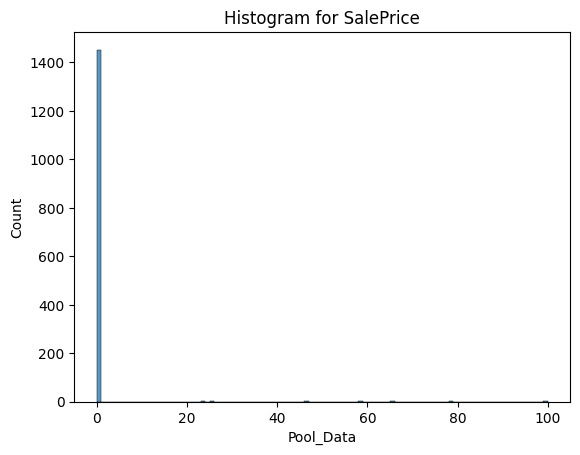

In [27]:
sns.histplot(df_train['Pool_Data'], bins=100, kde=False)
plt.title(f'Histogram for {column}')
plt.show()

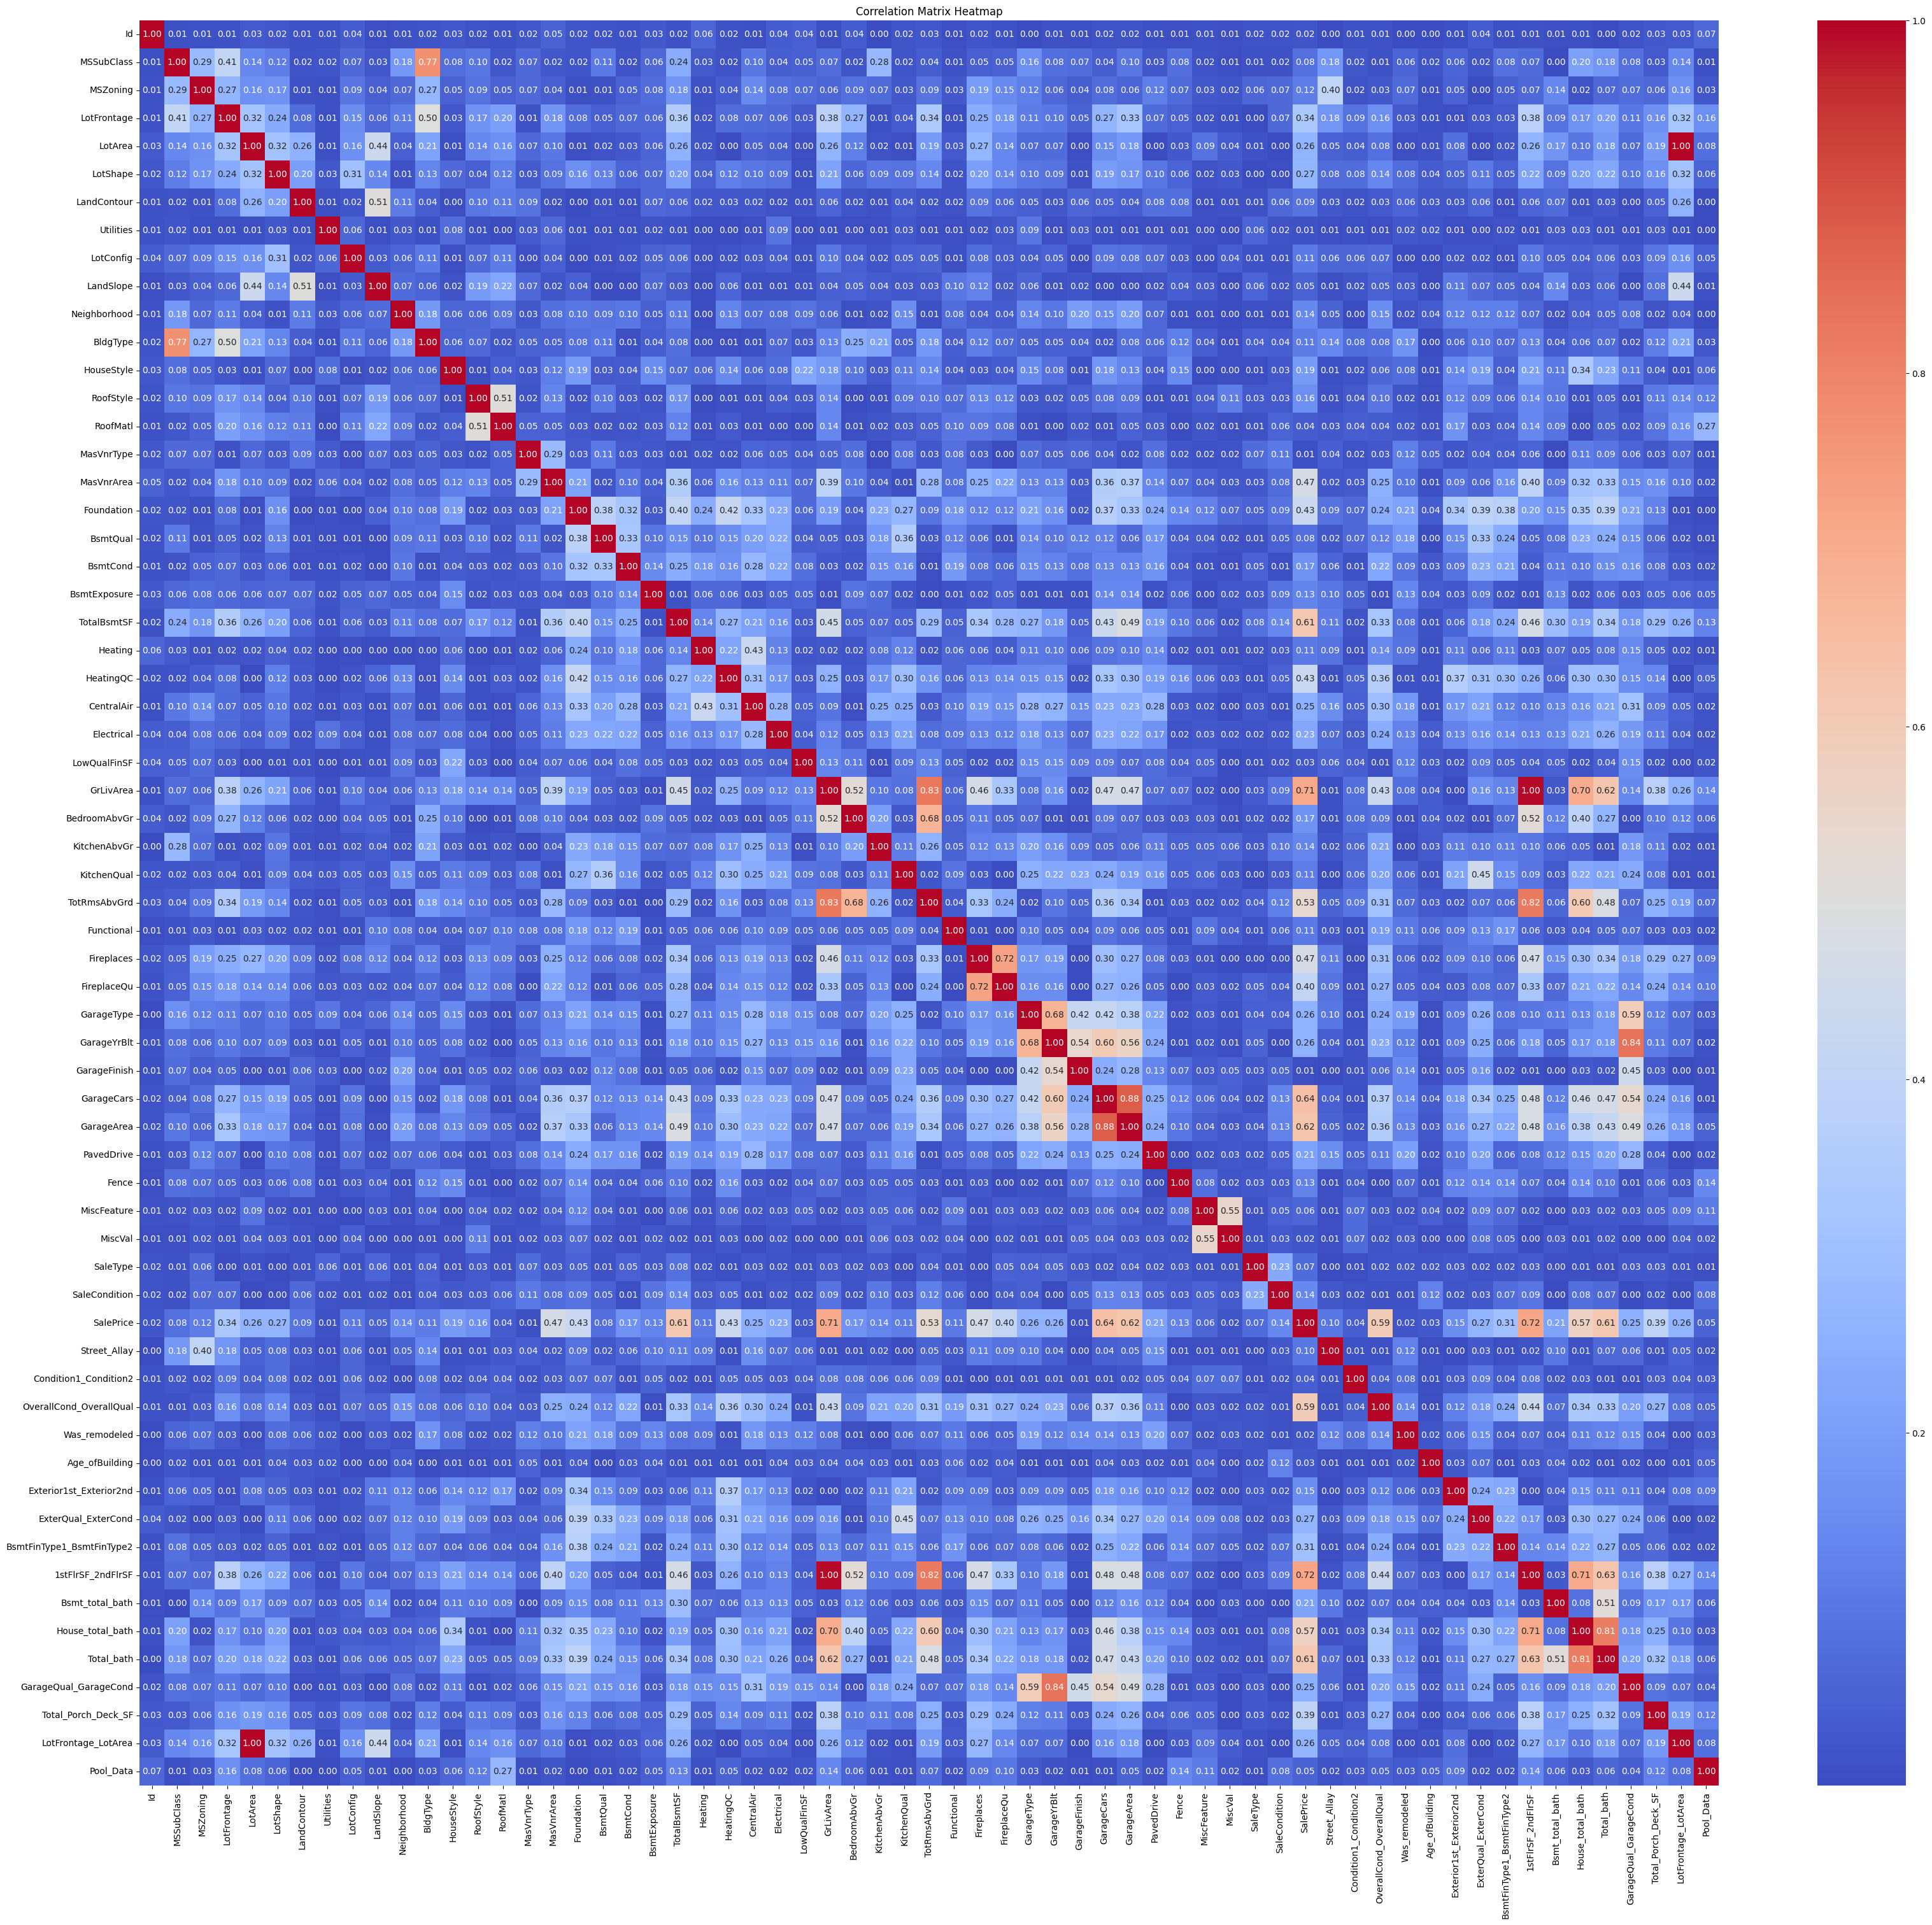

In [28]:
correlation_matrix = df_train.corr().abs()

# Set up the matplotlib figure
plt.figure(figsize=(40, 36))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title and show the plot
plt.title('Correlation Matrix Heatmap')
plt.show()

C:\Users\brand\AppData\Local\Temp\ipykernel_24480\3424686503.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.SalePrice,color='r')


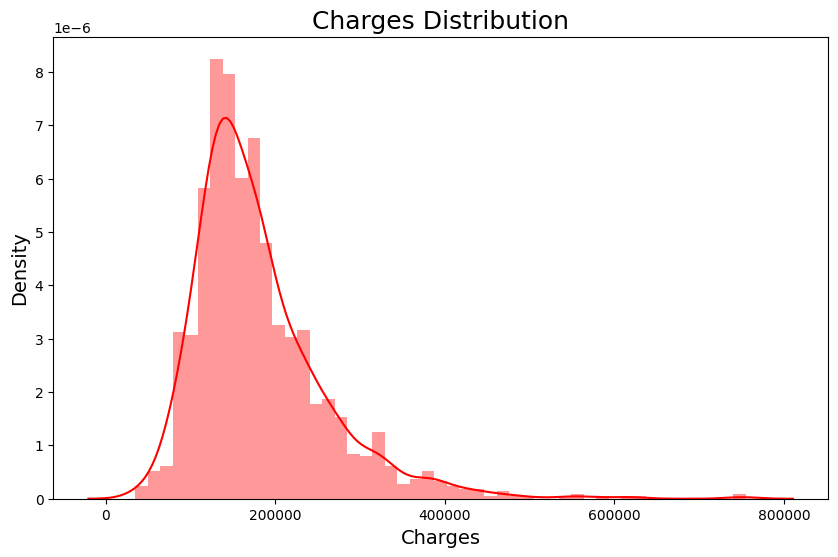

In [29]:
plt.figure(figsize=(10,6))
sns.distplot(df_train.SalePrice,color='r')
plt.title('Charges Distribution',size=18)
plt.xlabel('Charges',size=14)
plt.ylabel('Density',size=14)
plt.show()

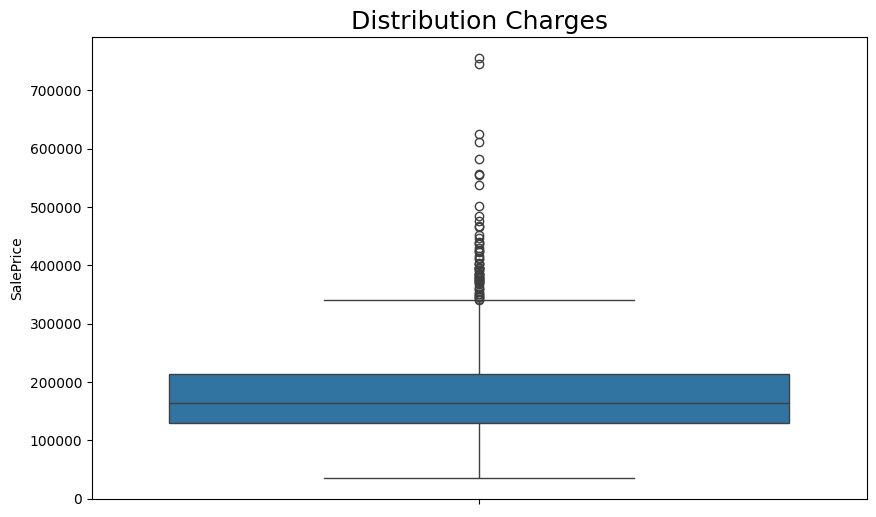

In [30]:
plt.figure(figsize = (10,6))
sns.boxplot(df_train['SalePrice'])
plt.title('Distribution Charges',size=18)
plt.show()

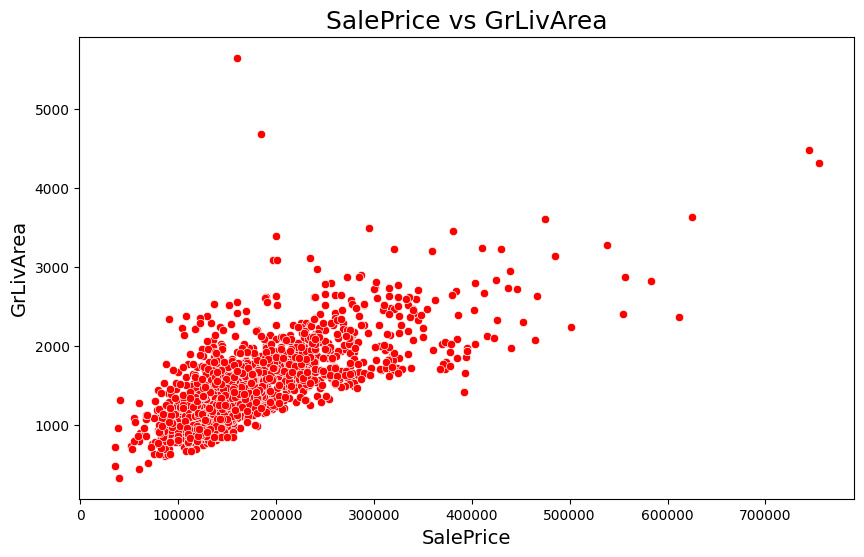

In [31]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='SalePrice',y='GrLivArea',color='r',data=df_train)
plt.title('SalePrice vs GrLivArea',size=18)
plt.xlabel('SalePrice',size=14)
plt.ylabel('GrLivArea',size=14)
plt.show()

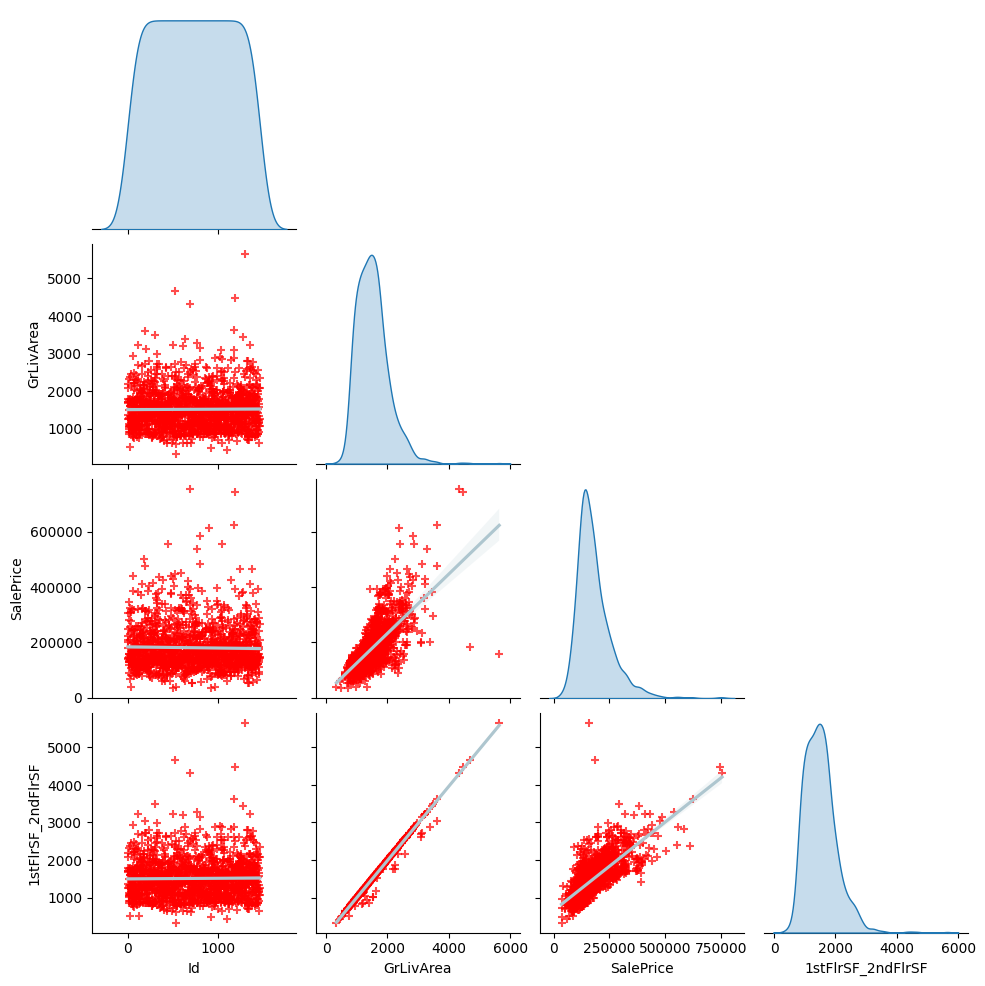

In [32]:
correlation_matrix = df_train.corr()

# Extract the correlation of each feature with SalePrice
saleprice_correlation = correlation_matrix['SalePrice']

# Sort the correlations in descending order
sorted_correlation = saleprice_correlation.abs().sort_values(ascending=False)
columns_to_drop = list(sorted_correlation[sorted_correlation < 0.70].index)
if "Id" in columns_to_drop:
    columns_to_drop.remove("Id")

# Drop the columns from the DataFrame
df_corr_dropped = df_train.drop(columns=columns_to_drop)

sns.pairplot(df_corr_dropped, 
                 markers="+",
                 diag_kind="kde",
                 kind='reg',
                 plot_kws={'line_kws':{'color':'#aec6cf'}, 
                           'scatter_kws': {'alpha': 0.7, 
                                           'color': 'red'}},
                 corner=True);

In [33]:
e=df_train
r=df_test

In [34]:
df_train=e
df_test=r
df_train.shape


(1460, 63)

In [35]:
correlation_matrix = df_train.corr()

# Extract the correlation of each feature with SalePrice
saleprice_correlation = correlation_matrix['SalePrice']

# Sort the correlations in descending order
sorted_correlation = saleprice_correlation.abs().sort_values(ascending=False)

# Print the sorted correlations
print("Correlation with SalePrice:")
print(sorted_correlation)

Correlation with SalePrice:
SalePrice            1.000000
1stFlrSF_2ndFlrSF    0.716883
GrLivArea            0.708624
GarageCars           0.640409
GarageArea           0.623431
                       ...   
Id                   0.021917
MiscVal              0.021190
Utilities            0.014314
MasVnrType           0.010695
GarageFinish         0.006799
Name: SalePrice, Length: 63, dtype: float64


In [36]:
columns_to_drop = list(sorted_correlation[sorted_correlation < 0.1].index)
if "Id" in columns_to_drop:
    columns_to_drop.remove("Id")

if "SalePrice" in columns_to_drop:
    columns_to_drop.remove("SalePrice")


# Drop the columns from the DataFrame
df_train = df_train.drop(columns=columns_to_drop)

df_test = df_test.drop(columns=columns_to_drop)     #drop also for test

# Print the columns that were dropped
print("Columns dropped:")
print(columns_to_drop)

# Print the shape of the filtered DataFrame
print("Shape of filtered DataFrame:", df_train.shape)

Columns dropped:
['Street_Allay', 'LandContour', 'MSSubClass', 'BsmtQual', 'SaleType', 'MiscFeature', 'Pool_Data', 'LandSlope', 'Condition1_Condition2', 'RoofMatl', 'Age_ofBuilding', 'LowQualFinSF', 'Was_remodeled', 'MiscVal', 'Utilities', 'MasVnrType', 'GarageFinish']
Shape of filtered DataFrame: (1460, 46)


In [37]:

#Use Z-score to drop any extra outliers
print(df_train.shape)
z_scores=stats.zscore(df_train)

abs_z_scores=np.abs(z_scores)
filtered=(abs_z_scores<15).all(axis=1)
df_train=df_train[filtered]
print(df_train.shape)


(1460, 46)
(1457, 46)


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         1457 non-null   int64  
 1   MSZoning                   1457 non-null   int8   
 2   LotFrontage                1457 non-null   float64
 3   LotArea                    1457 non-null   int64  
 4   LotShape                   1457 non-null   int8   
 5   LotConfig                  1457 non-null   int8   
 6   Neighborhood               1457 non-null   int8   
 7   BldgType                   1457 non-null   int8   
 8   HouseStyle                 1457 non-null   int8   
 9   RoofStyle                  1457 non-null   int8   
 10  MasVnrArea                 1457 non-null   float64
 11  Foundation                 1457 non-null   int8   
 12  BsmtCond                   1457 non-null   int8   
 13  BsmtExposure               1457 non-null   int8   
 1

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1458
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         1459 non-null   int64  
 1   MSZoning                   1459 non-null   int8   
 2   LotFrontage                1459 non-null   float64
 3   LotArea                    1459 non-null   int64  
 4   LotShape                   1459 non-null   int8   
 5   LotConfig                  1459 non-null   int8   
 6   Neighborhood               1459 non-null   int8   
 7   BldgType                   1459 non-null   int8   
 8   HouseStyle                 1459 non-null   int8   
 9   RoofStyle                  1459 non-null   int8   
 10  MasVnrArea                 1459 non-null   float64
 11  Foundation                 1459 non-null   int8   
 12  BsmtCond                   1459 non-null   int8   
 13  BsmtExposure               1459 non-null   int8   
 1

In [40]:
q=df_train
w=df_test

In [41]:
df_train=q
df_test=w

In [42]:

X = df_train.drop(columns=['Id', 'SalePrice'])
y = df_train['SalePrice']

#Correlation between features

cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
print(to_drop)

X = X.drop(columns=to_drop, axis=1)
df_test = df_test.drop(columns=to_drop, axis=1)

print(X.shape)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_test = scaler.transform(df_test.drop(columns=['Id']))


# Instantiate the XGBRegressor
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
'''

'''
# Fit the model to the training data
xgb_reg.fit(X_train, y_train)
print("Score XGB: ",xgb_reg.score(X_val,y_val))
# Predict on the test data
y_pred = xgb_reg.predict(X_val)
predicted_xgb=xgb_reg.predict(X_test)
results_df = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_xgb})
results_df.to_csv('predicted_prices.csv', index=False)
mse = mean_squared_error(y_val, y_pred)
print("XGBOOST MSE:", mse)

['TotRmsAbvGrd', 'FireplaceQu', 'GarageArea', '1stFlrSF_2ndFlrSF', 'House_total_bath', 'Total_bath', 'GarageQual_GarageCond', 'LotFrontage_LotArea']
(1457, 36)


C:\Users\brand\anaconda3\envs\New_Env_02_2024\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:59:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Score XGB:  0.9084053703993631
XGBOOST MSE: 513381030.20016545
